# Part 1: Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import math
import geopandas as gpd
import bs4
import re
import requests
import os
import pyarrow.parquet as pq
import glob
import matplotlib.pyplot as plt

### Uber Data

In [2]:
uber_rides_sample = pd.read_csv("uber_rides_sample.csv", index_col = 0)
uber_rides_sample.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
uber_rides_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 24238194 to 11951496
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  object 
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 13.7+ MB


### Download Yellow Taxi Data and get a sample dataset with its size close to Uber Dataset

In [4]:
# result = set()
# for filename in os.listdir("./yellow_taxi"):
#     if filename.endswith(".parquet"):
#         existing_columns = set(pq.ParquetFile("./yellow_taxi/"+filename).schema.names)
#         result = result.union(existing_columns)

# result

In [5]:
# Get Yellow Taxi Parquet files
def download_yellow_taxi_parquet_files():
    response = requests.get("https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page")
    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    yellow_records = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    if not os.path.exists("./yellow_taxi"):
        os.makedirs("./yellow_taxi")
    
    for record in yellow_records:
        pattern = r'yellow_tripdata_(2009|201[0-5])-\d{2}\.'
        link = record["href"]
        if re.search(pattern, link):
            filename = os.path.join("yellow_taxi", link.split("/")[-1])
            response = requests.get(link)
            
            with open(filename, "wb") as f:
                f.write(response.content)

In [6]:
"""
Comment the line below if no need to download the Yellow Taxi Parquet files.
"""

# download_yellow_taxi_parquet_files()

'\nComment the line below if no need to download the Yellow Taxi Parquet files.\n'

In [7]:
# Get Yellow Taxi Data sample
def generate_yellow_taxi_df():
    columns_to_select = ['DOLocationID',
                         'End_Lat',
                         'End_Lon',
                         'PULocationID',
                         'Passenger_Count',
                         'Start_Lat',
                         'Start_Lon',
                         'Total_Amt',
                         'Trip_Distance',
                         'Trip_Dropoff_DateTime',
                         'Trip_Pickup_DateTime',
                         'dropoff_datetime',
                         'dropoff_latitude',
                         'dropoff_longitude',
                         'passenger_count',
                         'pickup_datetime',
                         'pickup_latitude',
                         'pickup_longitude',
                         'total_amount',
                         'tpep_dropoff_datetime',
                         'tpep_pickup_datetime',
                         'trip_distance',
                         'Tip_Amt',
                         'tip_amount']

    directory = "./yellow_taxi"
    yellow_taix_df = pd.DataFrame()
    for filename in os.listdir(directory):
        if filename.endswith(".parquet"):
            existing_columns = set(pq.ParquetFile("./yellow_taxi/"+filename).schema.names)
            columns_to_read = list(set(columns_to_select) & existing_columns)
            table = pq.read_table("./yellow_taxi/"+filename, columns=columns_to_read)
            df = table.to_pandas()
            random_subset = df.sample(n=3000)
            yellow_taix_df = pd.concat([yellow_taix_df, random_subset], ignore_index=True)
    yellow_taix_df.to_csv("yellow_taxi_ride_sample.csv", index = False)

In [8]:
"""
Comment the line below if the Yellow Taxi Data sample already generated.
"""

# generate_yellow_taxi_df()

'\nComment the line below if the Yellow Taxi Data sample already generated.\n'

In [9]:
yellow_taxi_ride_sample = pd.read_csv("yellow_taxi_ride_sample.csv")
yellow_taxi_ride_sample.head()

,trip_distance,tip_amount,tpep_dropoff_datetime,PULocationID,total_amount,DOLocationID,passenger_count,tpep_pickup_datetime,Passenger_Count,Tip_Amt,...,Trip_Distance,End_Lat,Trip_Pickup_DateTime,End_Lon,dropoff_latitude,dropoff_datetime,dropoff_longitude,pickup_latitude,pickup_datetime,pickup_longitude
0,1.5,1.50,2011-07-20 06:58:52,170.0,8.10,230.0,1.0,2011-07-20 06:52:08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.9,1.26,2011-07-09 00:53:28,48.0,7.56,48.0,2.0,2011-07-09 00:48:14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.9,0.00,2011-07-14 10:36:55,140.0,9.00,142.0,2.0,2011-07-14 10:25:30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,0.00,2011-07-02 14:06:27,43.0,6.60,161.0,1.0,2011-07-02 13:59:48,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12.5,5.00,2011-07-16 21:26:28,138.0,36.10,231.0,3.0,2011-07-16 20:55:22,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
yellow_taxi_ride_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trip_distance          216000 non-null  float64
 1   tip_amount             216000 non-null  float64
 2   tpep_dropoff_datetime  180000 non-null  object 
 3   PULocationID           180000 non-null  float64
 4   total_amount           216000 non-null  float64
 5   DOLocationID           180000 non-null  float64
 6   passenger_count        216000 non-null  float64
 7   tpep_pickup_datetime   180000 non-null  object 
 8   Passenger_Count        36000 non-null   float64
 9   Tip_Amt                36000 non-null   float64
 10  Trip_Dropoff_DateTime  36000 non-null   object 
 11  Start_Lat              36000 non-null   float64
 12  Start_Lon              36000 non-null   float64
 13  Total_Amt              36000 non-null   float64
 14  Trip_Distance          36000 non-nul

### Data Preprocessing - Yellow Taxi Data
#### Combine columns with the same thing BUT have different column names

In [11]:
def convert_to_datetime(df):
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["Trip_Pickup_DateTime"] = pd.to_datetime(df["Trip_Pickup_DateTime"])
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    df["Trip_Dropoff_DateTime"] = pd.to_datetime(df["Trip_Dropoff_DateTime"])
    df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])
    return df

In [12]:
yellow_taxi_ride_sample = convert_to_datetime(yellow_taxi_ride_sample)
yellow_taxi_ride_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trip_distance          216000 non-null  float64       
 1   tip_amount             216000 non-null  float64       
 2   tpep_dropoff_datetime  180000 non-null  datetime64[ns]
 3   PULocationID           180000 non-null  float64       
 4   total_amount           216000 non-null  float64       
 5   DOLocationID           180000 non-null  float64       
 6   passenger_count        216000 non-null  float64       
 7   tpep_pickup_datetime   180000 non-null  datetime64[ns]
 8   Passenger_Count        36000 non-null   float64       
 9   Tip_Amt                36000 non-null   float64       
 10  Trip_Dropoff_DateTime  36000 non-null   datetime64[ns]
 11  Start_Lat              36000 non-null   float64       
 12  Start_Lon              36000 non-null   floa

In [13]:
def impute_pickup_datetime(row):
    if pd.notna(row['tpep_pickup_datetime']):
        return row['tpep_pickup_datetime']
    elif pd.notna(row['pickup_datetime']):
        return row['pickup_datetime']
    else:
        return row['Trip_Pickup_DateTime']
    
def impute_dropoff_datetime(row):
    if pd.notna(row['tpep_dropoff_datetime']):
        return row['tpep_dropoff_datetime']
    elif pd.notna(row['dropoff_datetime']):
        return row['dropoff_datetime']
    else:
        return row['Trip_Dropoff_DateTime']
    
def impute_trip_distance(row):
    if pd.notna(row['trip_distance']):
        return row['trip_distance']
    else:
        return row['Trip_Distance']
    
def impute_total_amount(row):
    if pd.notna(row['Total_Amt']):
        return row['Total_Amt']
    else:
        return row['total_amount']
    
def impute_pickup_lon(row):
    if pd.notna(row['pickup_longitude']):
        return row['pickup_longitude']
    else:
        return row['Start_Lon']
    
def impute_pickup_lat(row):
    if pd.notna(row['pickup_latitude']):
        return row['pickup_latitude']
    else:
        return row['Start_Lat']

def impute_dropoff_lon(row):
    if pd.notna(row['dropoff_longitude']):
        return row['dropoff_longitude']
    else:
        return row['End_Lon']

def impute_dropoff_lat(row):
    if pd.notna(row['dropoff_latitude']):
        return row['dropoff_latitude']
    else:
        return row['End_Lat']
    
def impute_passenger_count(row):
    if pd.notna(row['passenger_count']):
        return row['passenger_count']
    else:
        return row['Passenger_Count']
    
def impute_tip(row):
    if pd.notna(row['tip_amount']):
        return row['tip_amount']
    else:
        return row['Tip_Amt']

In [14]:
yellow_taxi_ride_sample['pickup_datetime'] = yellow_taxi_ride_sample.apply(impute_pickup_datetime, axis=1)
yellow_taxi_ride_sample['dropoff_datetime'] = yellow_taxi_ride_sample.apply(impute_dropoff_datetime, axis=1)
yellow_taxi_ride_sample['trip_distance'] = yellow_taxi_ride_sample.apply(impute_trip_distance, axis=1)
yellow_taxi_ride_sample['total_amount'] = yellow_taxi_ride_sample.apply(impute_total_amount, axis=1)
yellow_taxi_ride_sample['pickup_longitude'] = yellow_taxi_ride_sample.apply(impute_pickup_lon, axis=1)
yellow_taxi_ride_sample['pickup_latitude'] = yellow_taxi_ride_sample.apply(impute_pickup_lat, axis=1)
yellow_taxi_ride_sample['dropoff_longitude'] = yellow_taxi_ride_sample.apply(impute_dropoff_lon, axis=1)
yellow_taxi_ride_sample['dropoff_latitude'] = yellow_taxi_ride_sample.apply(impute_dropoff_lat, axis=1)
yellow_taxi_ride_sample['passenger_count'] = yellow_taxi_ride_sample.apply(impute_passenger_count, axis=1)
yellow_taxi_ride_sample['passenger_count'] = yellow_taxi_ride_sample['passenger_count'].astype(int)
yellow_taxi_ride_sample['tip_amount'] = yellow_taxi_ride_sample.apply(impute_tip, axis=1)
yellow_taxi_ride_sample = yellow_taxi_ride_sample.drop(columns=['tpep_pickup_datetime', 'Trip_Pickup_DateTime',\
                                                                'tpep_dropoff_datetime', 'Trip_Dropoff_DateTime',\
                                                                'Trip_Distance', 'Total_Amt',\
                                                                'Start_Lon', 'Start_Lat',\
                                                                'End_Lon', 'End_Lat', 'Passenger_Count', 'Tip_Amt'])
yellow_taxi_ride_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_distance      252000 non-null  float64       
 1   tip_amount         252000 non-null  float64       
 2   PULocationID       180000 non-null  float64       
 3   total_amount       252000 non-null  float64       
 4   DOLocationID       180000 non-null  float64       
 5   passenger_count    252000 non-null  int64         
 6   dropoff_latitude   72000 non-null   float64       
 7   dropoff_datetime   252000 non-null  datetime64[ns]
 8   dropoff_longitude  72000 non-null   float64       
 9   pickup_latitude    72000 non-null   float64       
 10  pickup_datetime    252000 non-null  datetime64[ns]
 11  pickup_longitude   72000 non-null   float64       
dtypes: datetime64[ns](2), float64(9), int64(1)
memory usage: 23.1 MB


#### Deal with  `longitude` , `latitude`, and `Location ID` related problems

In [15]:
nan_rows_PUlon = yellow_taxi_ride_sample[yellow_taxi_ride_sample['pickup_longitude'].isnull() & yellow_taxi_ride_sample['PULocationID'].notnull()]
nan_rows_PUlat = yellow_taxi_ride_sample[yellow_taxi_ride_sample['pickup_latitude'].isnull() & yellow_taxi_ride_sample['PULocationID'].notnull()]
nan_rows_DOlon = yellow_taxi_ride_sample[yellow_taxi_ride_sample['dropoff_longitude'].isnull() & yellow_taxi_ride_sample['DOLocationID'].notnull()]
nan_rows_DOlat = yellow_taxi_ride_sample[yellow_taxi_ride_sample['dropoff_latitude'].isnull() & yellow_taxi_ride_sample['DOLocationID'].notnull()]
nan_rows_lon_lat = pd.concat([nan_rows_PUlon, nan_rows_PUlat, nan_rows_DOlon, nan_rows_DOlat], axis=1)
nan_rows_lon_lat = nan_rows_lon_lat.loc[:, ~nan_rows_lon_lat.columns.duplicated()]
nan_rows_lon_lat

,trip_distance,tip_amount,PULocationID,total_amount,DOLocationID,passenger_count,dropoff_latitude,dropoff_datetime,dropoff_longitude,pickup_latitude,pickup_datetime,pickup_longitude
0,1.50,1.50,170.0,8.10,230.0,1,NaN,2011-07-20 06:58:52,NaN,NaN,2011-07-20 06:52:08,NaN
1,0.90,1.26,48.0,7.56,48.0,2,NaN,2011-07-09 00:53:28,NaN,NaN,2011-07-09 00:48:14,NaN
2,1.90,0.00,140.0,9.00,142.0,2,NaN,2011-07-14 10:36:55,NaN,NaN,2011-07-14 10:25:30,NaN
3,1.50,0.00,43.0,6.60,161.0,1,NaN,2011-07-02 14:06:27,NaN,NaN,2011-07-02 13:59:48,NaN
4,12.50,5.00,138.0,36.10,231.0,3,NaN,2011-07-16 21:26:28,NaN,NaN,2011-07-16 20:55:22,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
248995,2.30,0.00,263.0,11.50,142.0,2,NaN,2014-03-26 21:27:00,NaN,NaN,2014-03-26 21:16:00,NaN
248996,2.10,0.00,231.0,11.00,148.0,2,NaN,2014-03-07 19:33:53,NaN,NaN,2014-03-07 19:22:26,NaN
248997,1.50,0.00,50.0,8.00,162.0,1,NaN,2014-03-22 10:07:38,NaN,NaN,2014-03-22 09:59:54,NaN
248998,0.77,0.00,264.0,6.00,264.0,1,NaN,2014-03-26 16:40:00,NaN,NaN,2014-03-26 16:38:00,NaN


In [16]:
rest_rows = yellow_taxi_ride_sample.loc[~yellow_taxi_ride_sample.index.isin(nan_rows_lon_lat.index)]
rows_lon_lat_exist = yellow_taxi_ride_sample[yellow_taxi_ride_sample['pickup_longitude'].notnull() & yellow_taxi_ride_sample['pickup_latitude'].notnull()]
print(f"Check 'rows_lon_lat_exist' and 'nan_rows_lon_lat' forms a partition of 'yellow_taxi_ride_sample': {(rest_rows.copy().drop(['PULocationID', 'DOLocationID'], axis=1)).equals(rows_lon_lat_exist.copy().drop(['PULocationID', 'DOLocationID'], axis=1))}")

Check 'rows_lon_lat_exist' and 'nan_rows_lon_lat' forms a partition of 'yellow_taxi_ride_sample': True


In [17]:
gdf_polygons = gpd.read_file('./taxi_zones/taxi_zones.shp')
gdf_polygons.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [18]:
gdf_polygons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int64   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int64   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 14.5+ KB


In [19]:
def gdf_get_location(df):
    df = gdf_polygons.to_crs(4326)
    df['pickup_lon'] = df['geometry'].centroid.x
    df['pickup_lat'] = df['geometry'].centroid.y
    df['dropoff_lon'] = df['geometry'].centroid.x
    df['dropoff_lat'] = df['geometry'].centroid.y
    return df

In [20]:
gdf_polygons = gdf_get_location(gdf_polygons)
gdf_polygons.head()

/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_94542/3985826996.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['pickup_lon'] = df['geometry'].centroid.x
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_94542/3985826996.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['pickup_lat'] = df['geometry'].centroid.y
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_94542/3985826996.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['dropoff_lon'] = df['geometry'].centroid.x
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykerne

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",-74.174000,40.691831,-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",-73.831299,40.616745,-73.831299,40.616745
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",-73.847422,40.864473,-73.847422,40.864473
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752,-73.976968,40.723752
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",-74.188485,40.552659,-74.188485,40.552659


In [21]:
gdf_polygons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   OBJECTID     263 non-null    int64   
 1   Shape_Leng   263 non-null    float64 
 2   Shape_Area   263 non-null    float64 
 3   zone         263 non-null    object  
 4   LocationID   263 non-null    int64   
 5   borough      263 non-null    object  
 6   geometry     263 non-null    geometry
 7   pickup_lon   263 non-null    float64 
 8   pickup_lat   263 non-null    float64 
 9   dropoff_lon  263 non-null    float64 
 10  dropoff_lat  263 non-null    float64 
dtypes: float64(6), geometry(1), int64(2), object(2)
memory usage: 22.7+ KB


In [22]:
def merge_geo_df(geo_df, df):    
    # Merge nan_rows with geo_df to get the missing longtitude/latitude values
    # We use 'inner' merge to filter the rows with invalid location ID
    merged_nan_rows_PU = pd.merge(df, geo_df[['LocationID', 'pickup_lon', 'pickup_lat']],
                           left_on='PULocationID', right_on='LocationID', how='inner')
    merged_nan_rows = pd.merge(merged_nan_rows_PU, geo_df[['LocationID', 'dropoff_lon', 'dropoff_lat']],
                           left_on='DOLocationID', right_on='LocationID', how='inner')  
    return merged_nan_rows

In [23]:
nan_rows_lon_lat = merge_geo_df(gdf_polygons, nan_rows_lon_lat)
nan_rows_lon_lat['pickup_longitude'] = nan_rows_lon_lat['pickup_lon']
nan_rows_lon_lat['pickup_latitude'] = nan_rows_lon_lat['pickup_lat']
nan_rows_lon_lat['dropoff_longitude'] = nan_rows_lon_lat['dropoff_lon']
nan_rows_lon_lat['dropoff_latitude'] = nan_rows_lon_lat['dropoff_lat']
nan_rows_lon_lat = nan_rows_lon_lat.drop(columns=['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat',\
                                                  'LocationID_x', 'LocationID_y'])
nan_rows_lon_lat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175628 entries, 0 to 175627
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_distance      175628 non-null  float64       
 1   tip_amount         175628 non-null  float64       
 2   PULocationID       175628 non-null  float64       
 3   total_amount       175628 non-null  float64       
 4   DOLocationID       175628 non-null  float64       
 5   passenger_count    175628 non-null  int64         
 6   dropoff_latitude   175628 non-null  float64       
 7   dropoff_datetime   175628 non-null  datetime64[ns]
 8   dropoff_longitude  175628 non-null  float64       
 9   pickup_latitude    175628 non-null  float64       
 10  pickup_datetime    175628 non-null  datetime64[ns]
 11  pickup_longitude   175628 non-null  float64       
dtypes: datetime64[ns](2), float64(9), int64(1)
memory usage: 17.4 MB


In [24]:
yellow_taxi_ride_sample = pd.concat([nan_rows_lon_lat, rest_rows])
yellow_taxi_ride_sample = yellow_taxi_ride_sample.drop(columns=['PULocationID', 'DOLocationID'])
yellow_taxi_ride_sample

,trip_distance,tip_amount,total_amount,passenger_count,dropoff_latitude,dropoff_datetime,dropoff_longitude,pickup_latitude,pickup_datetime,pickup_longitude
0,1.50,1.5,8.1,1,40.759817,2011-07-20 06:58:52,-73.984196,40.747745,2011-07-20 06:52:08,-73.978491
1,1.52,2.0,9.8,1,40.759817,2011-07-24 09:30:00,-73.984196,40.747745,2011-07-24 09:20:00,-73.978491
2,1.30,0.0,10.4,2,40.759817,2011-07-12 18:25:30,-73.984196,40.747745,2011-07-12 18:10:03,-73.978491
3,1.00,5.0,11.7,1,40.759817,2011-07-13 22:16:53,-73.984196,40.747745,2011-07-13 22:09:31,-73.978491
4,1.60,0.0,7.8,1,40.759817,2011-07-02 11:40:23,-73.984196,40.747745,2011-07-02 11:31:00,-73.978491
...,...,...,...,...,...,...,...,...,...,...
251995,2.27,0.0,8.5,1,40.768220,2009-05-13 07:18:00,-73.984062,40.793835,2009-05-13 07:08:00,-73.974513
251996,2.60,2.3,14.0,1,40.734862,2009-05-12 11:12:11,-73.990920,40.711184,2009-05-12 10:50:36,-74.015817
251997,0.90,0.0,4.5,5,40.776805,2009-05-16 06:57:00,-73.921347,40.775105,2009-05-16 06:54:00,-73.909158
251998,4.34,0.0,16.1,2,40.713953,2009-05-13 11:38:00,-74.014185,40.759733,2009-05-13 11:14:00,-73.983365


In [25]:
yellow_taxi_ride_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247628 entries, 0 to 251999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_distance      247628 non-null  float64       
 1   tip_amount         247628 non-null  float64       
 2   total_amount       247628 non-null  float64       
 3   passenger_count    247628 non-null  int64         
 4   dropoff_latitude   247628 non-null  float64       
 5   dropoff_datetime   247628 non-null  datetime64[ns]
 6   dropoff_longitude  247628 non-null  float64       
 7   pickup_latitude    247628 non-null  float64       
 8   pickup_datetime    247628 non-null  datetime64[ns]
 9   pickup_longitude   247628 non-null  float64       
dtypes: datetime64[ns](2), float64(7), int64(1)
memory usage: 20.8 MB


### Data Preprocessing - Uber Data

In [26]:
uber_rides_sample.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [27]:
uber_rides_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 24238194 to 11951496
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  object 
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 13.7+ MB


In [28]:
#Check missing values
uber_rides_sample.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [29]:
uber_rides_sample['pickup_datetime'] = pd.to_datetime(uber_rides_sample['pickup_datetime'])
uber_rides_sample = uber_rides_sample.drop('key', axis=1) #Since Column 'key' has same values as Column 'pickup_datetime'
uber_rides_sample = uber_rides_sample.dropna() #Since there are very less missing values, we simply drop them
uber_rides_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 24238194 to 11951496
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        199999 non-null  float64            
 1   pickup_datetime    199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude   199999 non-null  float64            
 3   pickup_latitude    199999 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    199999 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 12.2 MB


### For Uber and Yellow Taxi data, 
#### remove out of region records

In [30]:
def remove_out_region(df):
    df = df[df['pickup_latitude'] >= 40.560445]
    df = df[df['pickup_latitude'] <= 40.908524]
    df = df[df['dropoff_latitude'] >= 40.560445]
    df = df[df['dropoff_latitude'] <= 40.908524]
    
    df = df[df['pickup_longitude'] >= -74.242330]
    df = df[df['pickup_longitude'] <= -73.71704]
    df = df[df['dropoff_longitude'] >= -74.242330]
    df = df[df['dropoff_longitude'] <= -73.71704]
    return df

In [31]:
yellow_taxi_ride_sample = remove_out_region(yellow_taxi_ride_sample)
uber_rides_sample = remove_out_region(remove_out_region(uber_rides_sample))

####  Calculate trip distance between the pickup and dropoff location

In [32]:
def calculate_trip_distance(row):
    pickup_latitude = row['pickup_latitude']
    pickup_longitude = row['pickup_longitude']
    dropoff_latitude = row['dropoff_latitude']
    dropoff_longitude = row['dropoff_longitude']
    
    lat1, lon1, lat2, lon2 = map(math.radians, [pickup_latitude, pickup_longitude,  dropoff_latitude, dropoff_longitude])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    dist = math.sqrt(dlat**2 + dlon**2)
    
    R = 6371
    distance = dist * R
    return distance
    

In [33]:
yellow_taxi_ride_sample['distance_PD'] = yellow_taxi_ride_sample.apply(calculate_trip_distance, axis=1)
uber_rides_sample['distance_PD'] = uber_rides_sample.apply(calculate_trip_distance, axis=1)

#### Filter out zero distance

In [34]:
def remove_zero_distance(df):
    condition = df['distance_PD'] == 0
    df = df.drop(df[condition].index)
    return df

In [35]:
yellow_taxi_ride_sample = remove_zero_distance(yellow_taxi_ride_sample)
uber_rides_sample = remove_zero_distance(uber_rides_sample)

### Cleaned Yellow Taxi Data sample and Uber Data sample

In [36]:
yellow_taxi_ride_sample

,trip_distance,tip_amount,total_amount,passenger_count,dropoff_latitude,dropoff_datetime,dropoff_longitude,pickup_latitude,pickup_datetime,pickup_longitude,distance_PD
0,1.50,1.5,8.1,1,40.759817,2011-07-20 06:58:52,-73.984196,40.747745,2011-07-20 06:52:08,-73.978491,1.484671
1,1.52,2.0,9.8,1,40.759817,2011-07-24 09:30:00,-73.984196,40.747745,2011-07-24 09:20:00,-73.978491,1.484671
2,1.30,0.0,10.4,2,40.759817,2011-07-12 18:25:30,-73.984196,40.747745,2011-07-12 18:10:03,-73.978491,1.484671
3,1.00,5.0,11.7,1,40.759817,2011-07-13 22:16:53,-73.984196,40.747745,2011-07-13 22:09:31,-73.978491,1.484671
4,1.60,0.0,7.8,1,40.759817,2011-07-02 11:40:23,-73.984196,40.747745,2011-07-02 11:31:00,-73.978491,1.484671
...,...,...,...,...,...,...,...,...,...,...,...
251995,2.27,0.0,8.5,1,40.768220,2009-05-13 07:18:00,-73.984062,40.793835,2009-05-13 07:08:00,-73.974513,3.039736
251996,2.60,2.3,14.0,1,40.734862,2009-05-12 11:12:11,-73.990920,40.711184,2009-05-12 10:50:36,-74.015817,3.820494
251997,0.90,0.0,4.5,5,40.776805,2009-05-16 06:57:00,-73.921347,40.775105,2009-05-16 06:54:00,-73.909158,1.368474
251998,4.34,0.0,16.1,2,40.713953,2009-05-13 11:38:00,-74.014185,40.759733,2009-05-13 11:14:00,-73.983365,6.136591


In [37]:
uber_rides_sample

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_PD
24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683468
27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457725
44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.905407
25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.837874
17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,5.674431
...,...,...,...,...,...,...,...,...
42598914,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,0.118316
16382965,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,2.460268
27804658,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,15.814454
20259894,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,3.680636


## Weather Data

In [38]:
path = './weather/'
all_files = glob.glob(path + "*.csv")
data_frames = []
for filename in all_files:
    df = pd.read_csv(filename)
    data_frames.append(df)
weather_data = pd.concat(data_frames, axis=0, ignore_index=True)

/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_94542/2213197053.py:5: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_94542/2213197053.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_94542/2213197053.py:5: DtypeWarning: Columns (8,9,17,18,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_94542/2213197053.py:5: DtypeWarning: Columns (17,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_94542/2213197053.py:5: DtypeWarning: Columns (9,13) have mixed

In [39]:
weather_data.head()

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate
0,72505394728,2012-01-01T00:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.05,37,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
1,72505394728,2012-01-01T01:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.07,37,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
2,72505394728,2012-01-01T02:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.08,37,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
3,72505394728,2012-01-01T03:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.06,37,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
4,72505394728,2012-01-01T04:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.07,37,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18


### Hourly Weather Dataset

In [40]:
weather_data_hourly = weather_data.iloc[:, 1:4].join(weather_data[['HourlyPrecipitation', 'HourlyWindSpeed']])
weather_data_hourly.head()

,DATE,LATITUDE,LONGITUDE,HourlyPrecipitation,HourlyWindSpeed
0,2012-01-01T00:51:00,40.77898,-73.96925,NaN,6.0
1,2012-01-01T01:51:00,40.77898,-73.96925,NaN,7.0
2,2012-01-01T02:51:00,40.77898,-73.96925,NaN,6.0
3,2012-01-01T03:51:00,40.77898,-73.96925,NaN,5.0
4,2012-01-01T04:51:00,40.77898,-73.96925,NaN,0.0


In [41]:
weather_data_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77972 entries, 0 to 77971
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 77972 non-null  object 
 1   LATITUDE             77972 non-null  float64
 2   LONGITUDE            77972 non-null  float64
 3   HourlyPrecipitation  39961 non-null  object 
 4   HourlyWindSpeed      73713 non-null  float64
dtypes: float64(3), object(2)
memory usage: 3.0+ MB


In [42]:
#Check missing values
weather_data_hourly.isnull().sum()

DATE                       0
LATITUDE                   0
LONGITUDE                  0
HourlyPrecipitation    38011
HourlyWindSpeed         4259
dtype: int64

In [43]:
print("Unique values in Latitude: ",weather_data_hourly['LATITUDE'].unique())
print("Unique values in Longtitude: ",weather_data_hourly['LONGITUDE'].unique())

Unique values in Latitude:  [40.77898]
Unique values in Longtitude:  [-73.96925]


In [44]:
#Since there is only one unique longtitude and latitude, which means that all the weather data are from the same place
#We drop the two columns "LATITUDE", "LONGTITUDE"

weather_data_hourly = weather_data_hourly.drop(columns=['LATITUDE', 'LONGITUDE'])

#### Fill in missing values

In [45]:
# Fills missing values in 'HourlyPrecipitation' with 0
weather_data_hourly['HourlyPrecipitation'].fillna(0, inplace=True)

# Fills missing values in 'HourlyWindSpeed' with the last known value in the same column
weather_data_hourly['HourlyWindSpeed'] = weather_data_hourly['HourlyWindSpeed'].fillna(method='ffill')

#Change 'DATE' column to Datetime type
weather_data_hourly['DATE'] = pd.to_datetime(weather_data_hourly['DATE'])

### Cleaned Hourly Weather Dataset

In [46]:
weather_data_hourly

,DATE,HourlyPrecipitation,HourlyWindSpeed
0,2012-01-01 00:51:00,0,6.0
1,2012-01-01 01:51:00,0,7.0
2,2012-01-01 02:51:00,0,6.0
3,2012-01-01 03:51:00,0,5.0
4,2012-01-01 04:51:00,0,0.0
...,...,...,...
77967,2010-12-31 19:51:00,0,5.0
77968,2010-12-31 20:51:00,0,7.0
77969,2010-12-31 21:51:00,0,7.0
77970,2010-12-31 22:51:00,0,6.0


In [47]:
weather_data_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77972 entries, 0 to 77971
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 77972 non-null  datetime64[ns]
 1   HourlyPrecipitation  77972 non-null  object        
 2   HourlyWindSpeed      77972 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.8+ MB


### Daily Weather Dataset

In [48]:
weather_data_daily = weather_data[['DATE','Sunrise','Sunset','DailyAverageWindSpeed','DailyPeakWindSpeed',
                                   'DailySustainedWindSpeed','DailyPrecipitation']]
weather_data_daily.head()

,DATE,Sunrise,Sunset,DailyAverageWindSpeed,DailyPeakWindSpeed,DailySustainedWindSpeed,DailyPrecipitation
0,2012-01-01T00:51:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01T01:51:00,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-01T02:51:00,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-01T03:51:00,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-01T04:51:00,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
weather_data_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77972 entries, 0 to 77971
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DATE                     77972 non-null  object 
 1   Sunrise                  1826 non-null   float64
 2   Sunset                   1826 non-null   float64
 3   DailyAverageWindSpeed    1246 non-null   float64
 4   DailyPeakWindSpeed       1242 non-null   float64
 5   DailySustainedWindSpeed  1249 non-null   float64
 6   DailyPrecipitation       1249 non-null   object 
dtypes: float64(5), object(2)
memory usage: 4.2+ MB


In [50]:
#Group by 'DATE' (daily)
date_format = '%Y-%m-%d'
weather_data_daily['DATE'] = pd.to_datetime(weather_data_daily['DATE'], format=date_format).dt.date
weather_data_daily['DATE'] = pd.to_datetime(weather_data_daily['DATE'])

def filter_rows(group):
    is_all_nan = group.iloc[:, 1:].isna().all(axis=1)
    if is_all_nan.all():
        return group.head(1)
    return group.dropna(subset=group.columns[1:], how='all')

date_group = weather_data_daily.groupby('DATE')
weather_data_daily = date_group.apply(filter_rows)
weather_data_daily['DATE'] = weather_data_daily['DATE'].dt.strftime('%Y-%m-%d')
weather_data_daily = weather_data_daily.reset_index(drop=True)
weather_data_daily

/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_94542/1860377389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_daily['DATE'] = pd.to_datetime(weather_data_daily['DATE'], format=date_format).dt.date
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_94542/1860377389.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_daily['DATE'] = pd.to_datetime(weather_data_daily['DATE'])


,DATE,Sunrise,Sunset,DailyAverageWindSpeed,DailyPeakWindSpeed,DailySustainedWindSpeed,DailyPrecipitation
0,2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-02,720.0,1640.0,NaN,NaN,NaN,NaN
2,2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-05,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2546,2015-12-27,719.0,1635.0,5.7,26.0,15.0,0.12
2547,2015-12-28,719.0,1636.0,8.3,28.0,18.0,0.03
2548,2015-12-29,720.0,1636.0,7.0,24.0,18.0,0.45
2549,2015-12-30,720.0,1637.0,4.1,13.0,9.0,0.19


In [51]:
weather_data_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DATE                     2551 non-null   object 
 1   Sunrise                  1826 non-null   float64
 2   Sunset                   1826 non-null   float64
 3   DailyAverageWindSpeed    1246 non-null   float64
 4   DailyPeakWindSpeed       1242 non-null   float64
 5   DailySustainedWindSpeed  1249 non-null   float64
 6   DailyPrecipitation       1249 non-null   object 
dtypes: float64(5), object(2)
memory usage: 139.6+ KB


#### Fill in the missing values according the Hourly Weather Data

In [52]:
weather_data_hourly_copy = weather_data_hourly.copy()
weather_data_hourly_copy['DATE'] = pd.to_datetime(weather_data_hourly_copy['DATE'], format=date_format).dt.date
weather_data_hourly_copy['DATE'] = pd.to_datetime(weather_data_hourly_copy['DATE'])

daily_avg_windspeed = weather_data_hourly_copy.groupby('DATE')['HourlyWindSpeed'].mean()
daily_peak_windspeed = weather_data_hourly_copy.groupby('DATE')['HourlyWindSpeed'].max()
daily_sustained_windspeed = weather_data_hourly_copy.groupby('DATE')['HourlyWindSpeed'].apply(lambda x: x.value_counts().idxmax())
weather_data_hourly_copy['HourlyPrecipitation'] = weather_data_hourly_copy['HourlyPrecipitation'].str.replace('s', '')
weather_data_hourly_copy['HourlyPrecipitation'] = weather_data_hourly_copy['HourlyPrecipitation'].replace('T', 0.0).astype(float)
daily_precipitation = weather_data_hourly_copy.groupby('DATE')['HourlyPrecipitation'].sum()

weather_data_daily['DailyAverageWindSpeed'] = weather_data_daily.apply(lambda row: 
                                                row['DailyAverageWindSpeed'] 
                                                if pd.notna(row['DailyAverageWindSpeed']) 
                                                else daily_avg_windspeed[row['DATE']], 
                                                axis=1)
weather_data_daily['DailyPeakWindSpeed'] = weather_data_daily.apply(lambda row: 
                                                row['DailyPeakWindSpeed'] 
                                                if pd.notna(row['DailyPeakWindSpeed']) 
                                                else daily_peak_windspeed[row['DATE']], 
                                                axis=1)
weather_data_daily['DailySustainedWindSpeed'] = weather_data_daily.apply(lambda row: 
                                                row['DailySustainedWindSpeed'] 
                                                if pd.notna(row['DailySustainedWindSpeed']) 
                                                else daily_sustained_windspeed[row['DATE']], 
                                                axis=1)
weather_data_daily['DailyPrecipitation'] = weather_data_daily.apply(lambda row: 
                                                row['DailyPrecipitation'] 
                                                if pd.notna(row['DailyPrecipitation']) 
                                                else daily_precipitation[row['DATE']], 
                                                axis=1)

weather_data_daily['DATE'] = pd.to_datetime(weather_data_daily['DATE'])


In [53]:
weather_data_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   DATE                     2551 non-null   datetime64[ns]
 1   Sunrise                  1826 non-null   float64       
 2   Sunset                   1826 non-null   float64       
 3   DailyAverageWindSpeed    2551 non-null   float64       
 4   DailyPeakWindSpeed       2551 non-null   float64       
 5   DailySustainedWindSpeed  2551 non-null   float64       
 6   DailyPrecipitation       2551 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 139.6+ KB


### Cleaned Daily Weather Datasets

In [54]:
sunrise_sunset = weather_data_daily.copy().dropna()
sunrise_sunset

,DATE,Sunrise,Sunset,DailyAverageWindSpeed,DailyPeakWindSpeed,DailySustainedWindSpeed,DailyPrecipitation
1,2009-01-02,720.0,1640.0,6.812500,16.0,3.0,0.0
5,2009-01-06,720.0,1644.0,7.200000,11.0,9.0,0.12
6,2009-01-07,720.0,1645.0,9.846154,18.0,10.0,1.82
9,2009-01-10,720.0,1648.0,7.905660,15.0,10.0,0.41
10,2009-01-11,720.0,1649.0,7.236842,13.0,7.0,0.51
...,...,...,...,...,...,...,...
2546,2015-12-27,719.0,1635.0,5.700000,26.0,15.0,0.12
2547,2015-12-28,719.0,1636.0,8.300000,28.0,18.0,0.03
2548,2015-12-29,720.0,1636.0,7.000000,24.0,18.0,0.45
2549,2015-12-30,720.0,1637.0,4.100000,13.0,9.0,0.19


In [55]:
sunrise_sunset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 1 to 2550
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   DATE                     1826 non-null   datetime64[ns]
 1   Sunrise                  1826 non-null   float64       
 2   Sunset                   1826 non-null   float64       
 3   DailyAverageWindSpeed    1826 non-null   float64       
 4   DailyPeakWindSpeed       1826 non-null   float64       
 5   DailySustainedWindSpeed  1826 non-null   float64       
 6   DailyPrecipitation       1826 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 114.1+ KB


In [56]:
weather_data_daily = weather_data_daily.drop(columns=['Sunrise','Sunset'])
weather_data_daily

,DATE,DailyAverageWindSpeed,DailyPeakWindSpeed,DailySustainedWindSpeed,DailyPrecipitation
0,2009-01-01,11.041667,18.0,8.0,0.0
1,2009-01-02,6.812500,16.0,3.0,0.0
2,2009-01-03,9.875000,15.0,8.0,0.0
3,2009-01-04,7.370370,10.0,8.0,0.0
4,2009-01-05,6.925926,11.0,5.0,0.0
...,...,...,...,...,...
2546,2015-12-27,5.700000,26.0,15.0,0.12
2547,2015-12-28,8.300000,28.0,18.0,0.03
2548,2015-12-29,7.000000,24.0,18.0,0.45
2549,2015-12-30,4.100000,13.0,9.0,0.19


In [57]:
weather_data_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   DATE                     2551 non-null   datetime64[ns]
 1   DailyAverageWindSpeed    2551 non-null   float64       
 2   DailyPeakWindSpeed       2551 non-null   float64       
 3   DailySustainedWindSpeed  2551 non-null   float64       
 4   DailyPrecipitation       2551 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 99.8+ KB


# Part 2: Storing Data

In [58]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///project.db', echo=True)
# Base.metadata.create_all(engine)

### Four tables

In [59]:
uber_rides_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193514 entries, 24238194 to 11951496
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        193514 non-null  float64            
 1   pickup_datetime    193514 non-null  datetime64[ns, UTC]
 2   pickup_longitude   193514 non-null  float64            
 3   pickup_latitude    193514 non-null  float64            
 4   dropoff_longitude  193514 non-null  float64            
 5   dropoff_latitude   193514 non-null  float64            
 6   passenger_count    193514 non-null  int64              
 7   distance_PD        193514 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 13.3 MB


In [60]:
weather_data_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77972 entries, 0 to 77971
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 77972 non-null  datetime64[ns]
 1   HourlyPrecipitation  77972 non-null  object        
 2   HourlyWindSpeed      77972 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.8+ MB


In [61]:
import sqlite3
connection = sqlite3.connect("project.db")

#Yellow Taxi trips
with connection:
    connection.execute(
        """
        CREATE TABLE IF NOT EXISTS yellow_taxi_ride (
            id INTEGER PRIMARY KEY,
            trip_distance REAL,
            passenger_count INTEGER,
            total_amount REAL,
            dropoff_datetime DATETIME,
            pickup_longitude REAL,
            pickup_latitude REAL,
            dropoff_latitude REAL,
            dropoff_longitude REAL,
            pickup_datetime DATETIME,
            distance_PD REAL,
            tip_amount REAL
        );
        """
    )

#Uber trips
with connection:
    connection.execute(
        """
        CREATE TABLE IF NOT EXISTS uber_rides (
            id INTEGER PRIMARY KEY,
            fare_amount REAL,
            pickup_datetime DATETIME,
            pickup_longitude REAL,
            pickup_latitude REAL,
            dropoff_longitude REAL,
            dropoff_latitude REAL,
            passenger_count INTEGER,
            distance_PD REAL
        );
        """
    )
    
#Hourly Weather
with connection:
    connection.execute(
        """
        CREATE TABLE IF NOT EXISTS hourly_weather_data (
            id INTEGER PRIMARY KEY,
            DATE DATETIME,
            HourlyPrecipitation REAL,
            HourlyWindSpeed REAL
        );
        """
    )
    
#Daily Weather
with connection:
    connection.execute(
        """
        CREATE TABLE IF NOT EXISTS daily_weather_data (
            id INTEGER PRIMARY KEY,
            DATE DATETIME,
            DailyAverageWindSpeed REAL,
            DailyPeakWindSpeed REAL,
            DailySustainedWindSpeed REAL,
            DailyPrecipitation REAL
        );
        """
    )

In [62]:
weather_data_daily.columns


Index(['DATE', 'DailyAverageWindSpeed', 'DailyPeakWindSpeed',
       'DailySustainedWindSpeed', 'DailyPrecipitation'],
      dtype='object')

In [63]:
with engine.connect() as conn:
    yellow_taxi_ride_sample.to_sql('yellow_taxi_ride', conn, if_exists='replace', index=False)
    uber_rides_sample.to_sql('uber_rides', conn, if_exists='replace', index=False)
    weather_data_hourly.to_sql('hourly_weather_data', conn, if_exists='replace', index=False)
    weather_data_daily.to_sql('daily_weather_data', conn, if_exists='replace', index=False)

2023-04-30 05:05:58,890 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("yellow_taxi_ride")
2023-04-30 05:05:58,890 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-30 05:05:58,891 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("yellow_taxi_ride")
2023-04-30 05:05:58,891 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-30 05:05:58,891 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2023-04-30 05:05:58,891 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-30 05:05:58,892 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("yellow_taxi_ride")
2023-04-30 05:05:58,892 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-30 05:05:58,893 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2023-04-30 05:05:58,893 INFO sqlalchemy.engine.Engine [raw sql] ('yellow_taxi_ride',)
2023-04-30 05:05:58,893 INFO sqlalchemy.engine.Engine PR

2023-04-30 05:06:00,535 INFO sqlalchemy.engine.Engine [no key 0.00029s] ()
2023-04-30 05:06:00,535 INFO sqlalchemy.engine.Engine COMMIT
2023-04-30 05:06:01,255 INFO sqlalchemy.engine.Engine INSERT INTO uber_rides (fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, "distance_PD") VALUES (?, ?, ?, ?, ?, ?, ?, ?)
2023-04-30 05:06:01,256 INFO sqlalchemy.engine.Engine [generated in 0.57764s] ((7.5, '2015-05-07 19:52:06.000000', -73.99981689453125, 40.73835372924805, -73.99951171875, 40.72321701049805, 1, 1.683468372889847), (7.7, '2009-07-17 20:04:56.000000', -73.994355, 40.728225, -73.99471, 40.750325, 1, 2.4577249023006513), (12.9, '2009-08-24 21:45:00.000000', -74.005043, 40.74077, -73.962565, 40.772647, 1, 5.905407110501063), (5.3, '2009-06-26 08:22:21.000000', -73.976124, 40.790844, -73.965316, 40.803349, 3, 1.837873830108156), (16.0, '2014-08-28 17:47:00.000000', -73.925023, 40.744085, -73.97308199999999, 40.761247, 5

2023-04-30 05:06:01,665 INFO sqlalchemy.engine.Engine 
CREATE TABLE daily_weather_data (
	"DATE" DATETIME, 
	"DailyAverageWindSpeed" FLOAT, 
	"DailyPeakWindSpeed" FLOAT, 
	"DailySustainedWindSpeed" FLOAT, 
	"DailyPrecipitation" TEXT
)


2023-04-30 05:06:01,665 INFO sqlalchemy.engine.Engine [no key 0.00026s] ()
2023-04-30 05:06:01,666 INFO sqlalchemy.engine.Engine COMMIT
2023-04-30 05:06:01,673 INFO sqlalchemy.engine.Engine INSERT INTO daily_weather_data ("DATE", "DailyAverageWindSpeed", "DailyPeakWindSpeed", "DailySustainedWindSpeed", "DailyPrecipitation") VALUES (?, ?, ?, ?, ?)
2023-04-30 05:06:01,673 INFO sqlalchemy.engine.Engine [generated in 0.00517s] (('2009-01-01 00:00:00.000000', 11.041666666666666, 18.0, 8.0, 0.0), ('2009-01-02 00:00:00.000000', 6.8125, 16.0, 3.0, 0.0), ('2009-01-03 00:00:00.000000', 9.875, 15.0, 8.0, 0.0), ('2009-01-04 00:00:00.000000', 7.37037037037037, 10.0, 8.0, 0.0), ('2009-01-05 00:00:00.000000', 6.925925925925926, 11.0, 5.0, 0.0), ('2009-01-06 00:00:00.0

In [64]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute("SELECT name, sql FROM sqlite_master WHERE type='table'")
tables = cur.fetchall()

with open('schema.sql', 'w') as f:
    for table in tables:
        f.write(f'{table[1]};\n')
        
cur.close()
conn.close()

# Part 3: Understanding Data

## Query 1

In [65]:
query1 = """
SELECT 
    strftime('%H', pickup_datetime) AS hour_of_day,
    COUNT(*) AS ride_count
FROM 
    yellow_taxi_ride 
WHERE 
    pickup_datetime BETWEEN '2009-01-01' AND '2015-06-30'
GROUP BY 
    hour_of_day 
ORDER BY 
    ride_count DESC;
"""

In [66]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query1)
results1 = cur.fetchall()

for row in results1:
    print(row)

conn.close()

('19', 13498)
('18', 13002)
('20', 12688)
('21', 12379)
('22', 12166)
('17', 10806)
('23', 10664)
('14', 10649)
('12', 10610)
('13', 10586)
('15', 10360)
('09', 10057)
('11', 9910)
('08', 9762)
('10', 9680)
('16', 8900)
('00', 8594)
('07', 7786)
('01', 6291)
('02', 4839)
('06', 4462)
('03', 3562)
('04', 2525)
('05', 2081)


## Query 2

In [67]:
query2 = """
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(*) AS ride_count
FROM 
    uber_rides
WHERE 
    pickup_datetime BETWEEN '2009-01-01' AND '2015-06-30'
GROUP BY 
    day_of_week 
ORDER BY 
    ride_count DESC;
"""

In [68]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query2)
results2 = cur.fetchall()

for row in results2:
    print(row)

conn.close()

('5', 29845)
('6', 29320)
('4', 29050)
('3', 28068)
('2', 27197)
('0', 25572)
('1', 24398)


## Query 3

In [69]:
query3 = """
SELECT CAST((SELECT distance_PD
             FROM (
               SELECT distance_PD, NTILE(100) OVER (ORDER BY distance_PD) AS percentile
               FROM (
                 SELECT distance_PD FROM yellow_taxi_ride WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-07-31'
                 UNION ALL
                 SELECT distance_PD FROM uber_rides WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-07-31'
               ) AS hired_trips
             )
             WHERE percentile = 95
             LIMIT 1) AS REAL) AS percentile_95;
"""

In [70]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query3)
results3 = cur.fetchall()

for row in results3:
    print(row)

conn.close()

(11.713853379287501,)


## Query 4

In [71]:
query4 = """
SELECT
    date(date_time) AS date,
    SUM(num_rides) AS num_rides,
    AVG(avg_distance) AS avg_distance
FROM
    (
    SELECT
        dropoff_datetime AS date_time,
        1 AS num_rides,
        trip_distance AS avg_distance
    FROM
        yellow_taxi_ride
    WHERE
        strftime('%Y-%m', dropoff_datetime) BETWEEN '2009-01' AND '2009-06'
    
    UNION ALL
    
    SELECT
        pickup_datetime AS date_time,
        1 AS num_rides,
        distance_PD AS avg_distance
    FROM
        uber_rides
    WHERE
        strftime('%Y-%m', pickup_datetime) BETWEEN '2009-01' AND '2009-06'
    ) AS hired_rides
GROUP BY
    date
ORDER BY
    num_rides DESC
LIMIT
    10;
"""

In [72]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query4)
results4 = cur.fetchall()

for row in results4:
    print(row)

conn.close()

('2009-02-20', 226, 2.8993068931679518)
('2009-04-08', 223, 2.632999962486695)
('2009-03-19', 221, 2.9054342526139543)
('2009-04-04', 220, 2.6808280416304053)
('2009-04-03', 219, 2.9619808354353157)
('2009-01-31', 217, 3.0448587188949863)
('2009-04-18', 214, 3.0751796725774976)
('2009-05-16', 212, 2.956430946478384)
('2009-02-21', 211, 2.625045120738974)
('2009-05-08', 210, 3.191157030820873)


## Query 5

In [87]:
query5 = """
SELECT 
    DATE(pickup_datetime) AS date, 
    AVG(DailyAverageWindSpeed) AS avg_wind_speed, 
    SUM(num_trips) AS num_hired_trips
FROM 
    (
        SELECT 
            pickup_datetime, 
            1 AS num_trips 
        FROM 
            uber_rides 
        UNION ALL 
        SELECT 
            pickup_datetime, 
            1 AS num_trips 
        FROM 
            yellow_taxi_ride 
    ) AS hired_trips
    JOIN daily_weather_data ON DATE(pickup_datetime) = DATE 
WHERE 
    strftime('%Y', pickup_datetime) = '2014'
GROUP BY 
    date
ORDER BY 
    avg_wind_speed DESC 
LIMIT 
    10;
"""

In [90]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query5)
results5 = cur.fetchall()

for row in results5:
    print(row)

conn.close()

## Query 6

In [88]:
query6 = """
SELECT 
    strftime('%Y-%m-%d %H:00:00', coalesce(yt.pickup_datetime, ur.pickup_datetime)) AS hour, 
    COUNT(DISTINCT yt.pickup_datetime || ur.pickup_datetime) AS num_trips, 
    SUM(dw.DailyPrecipitation) AS total_precipitation, 
    AVG(dw.DailySustainedWindSpeed) AS avg_wind_speed 
FROM 
    (SELECT pickup_datetime FROM yellow_taxi_ride 
     UNION ALL 
     SELECT pickup_datetime FROM uber_rides) AS yt_ur 
    LEFT JOIN yellow_taxi_ride yt ON yt.pickup_datetime = yt_ur.pickup_datetime 
    LEFT JOIN uber_rides ur ON ur.pickup_datetime = yt_ur.pickup_datetime 
    INNER JOIN daily_weather_data dw ON strftime('%Y-%m-%d', coalesce(yt.pickup_datetime, ur.pickup_datetime)) = dw.DATE 
WHERE 
    coalesce(yt.pickup_datetime, ur.pickup_datetime) BETWEEN '2012-10-22 00:00:00' AND '2012-11-05 23:59:59' 
    AND dw.DATE BETWEEN '2012-10-22' AND '2012-11-05' 
GROUP BY 
    hour 
ORDER BY 
    num_trips DESC;
"""

In [89]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query6)
results6 = cur.fetchall()

for row in results6:
    print(row)

conn.close()

# Part 4: Visualizing Data

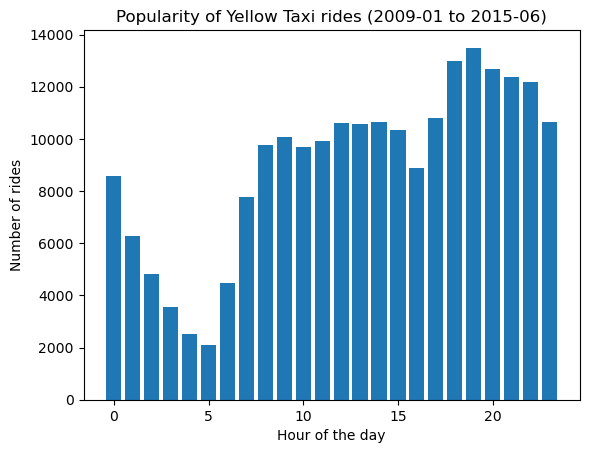

In [77]:
# 1
x = [int(row[0]) for row in results1]
y = [row[1] for row in results1]

fig, ax = plt.subplots()
ax.bar(x, y)

ax.set_xlabel('Hour of the day')
ax.set_ylabel('Number of rides')
ax.set_title('Popularity of Yellow Taxi rides (2009-01 to 2015-06)')

plt.show()

In [91]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()

cur.execute("""
    SELECT strftime('%m', pickup_datetime) AS month, 
           AVG(trip_distance) AS avg_distance, 
           1.645 * STDDEV(trip_distance) / COUNT(*) AS error
    FROM yellow_taxi_ride
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2015-06-30'
    GROUP BY month
    UNION
    SELECT strftime('%m', pickup_datetime) AS month, 
           AVG(distance_PD) AS avg_distance, 
           1.645 * STDDEV(distance_PD) / COUNT(*) AS error
    FROM uber_rides
    WHERE pickup_datetime BETWEEN '2010-01-01' AND '2015-06-30'
    GROUP BY month
""")

# fetch the results as a pandas dataframe
results = pd.DataFrame(cursor.fetchall(), columns=['month', 'avg_distance', 'error'])

# set the month column as the index
results.set_index('month', inplace=True)

# convert the index to datetime format for proper sorting
results.index = pd.to_datetime(results.index, format='%m')

# sort the dataframe by month
results.sort_index(inplace=True)

# create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# plot the data as a line chart with error bars
ax.errorbar(results.index, results.avg_distance, yerr=results.error, fmt='-o')

# set the title and labels
ax.set_title('Average Distance Traveled per Month for Yellow Taxis and Ubers')
ax.set_xlabel('Month')
ax.set_ylabel('Average Distance Traveled')

# show the plot
plt.show()


OperationalError: no such function: STDDEV